# Data Exploration of Chicago Crimes Data

## Table of Contents
* [Description of Columns](#col_description)
* [Reading in Cleaned Dataset](#read_data)
* [Plotting Function](#plot_func)
* [Most and Least Common Types of Crimes](#type)
* [All Crimes and Homicides by Region](#region)
* [All Crimes and Homicides by Community Area](#comm_areas)
* [Crimes and Homicides by Date Columns](#dates)  
    - [Date](#date)  
    - [Time of Day](#time)  
    - [Season](#season)  

<a id="col_description">

## Description of Columns
The original column descriptions from the City of Chicago 
[website](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2).

| Column Name  | Column Description |  
| :-:    | :-: |  
| Date         | Date when the incident occurred (sometimes an estimate) |
| Primary Type | The primary description of the IUCR code |
| Location Description | Description of the location where the incident occurred |
| Arrest | Indicates whether an arrest was made |
| Domestic | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence act |
| Community Area | Indicates the community area where the incident occurred (Chicago has 77 community areas) |
| Year | The year the incident occurred |
| Location | The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block |

<a id="read_data">

## Reading in the Cleaned Dataset

In [153]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [167]:
crimes = pd.read_csv('Data/crimes_cleaned.csv', parse_dates=['Date'])

In [168]:
print("Number of Crimes from {} to {}: {:,d}".format(crimes.Date.min(),crimes.Date.max(),crimes.shape[0]))
print("Approximate Average Crimes per Day: {:,.0f}".format(crimes.shape[0]/(122*30))) #122 months x 30 days per month

Number of Crimes from 2010-01-01 00:00:00 to 2020-02-29 23:59:00: 3,011,993
Approximate Average Crimes per Day: 823


<a id="plot_func">

## Plotting Function
To avoid needlessly repeating code.

In [130]:
#setting the default background for the plots
sns.set(style="whitegrid")

#defining the plotting function
def plot_crime(data, x_col, y_col, title, fig_size=(20,10)):
    """
        function to create and show a bar chart using the provided data and columns
        
        inputs:
            data     : pandas dataframe containing the data to display
            x_col    : string containing the column name for the X variable (must be a column in data)
            y_col    : string containing the column name for the Y variable (must be a column in data)
            title    : string containing the title for the bar chart
            fig_size : (optional) 2 dimensional tuple containing the size of the bar chart
        
        output:
            None
    """
    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.barplot(data=data, x=x_col, y=y_col)
    plt.title(title, fontsize=20)
    plt.xlabel(None)
    plt.ylabel(None)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.show()

<a id="region">

## All Crimes and Homicides by Region

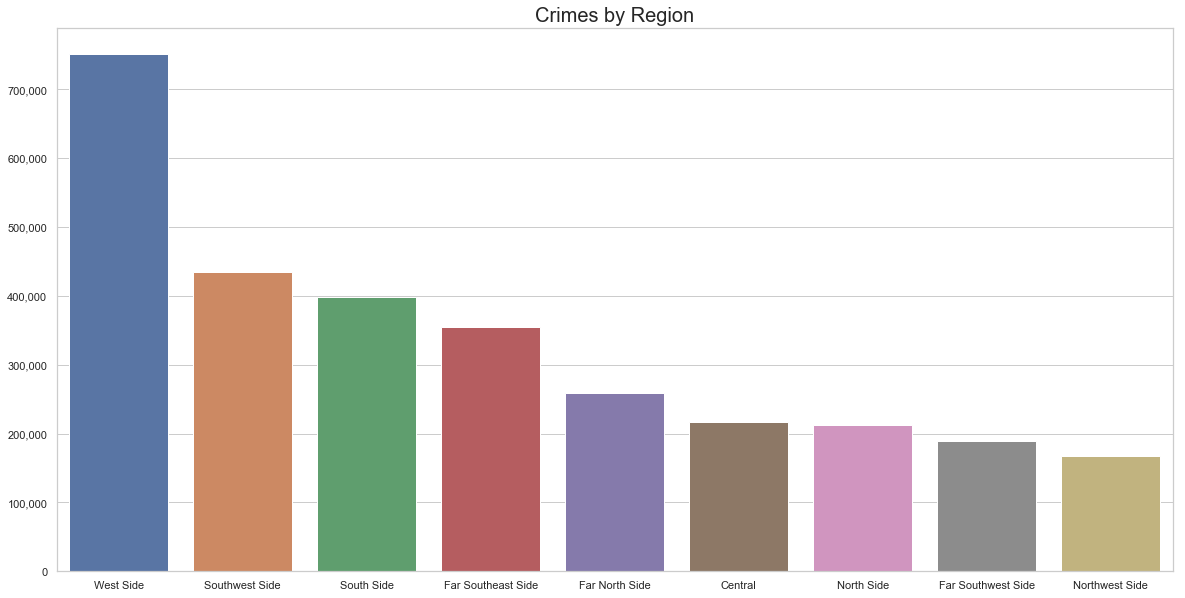

In [131]:
#grouping all crimes by region
region_counts = crimes.groupby(['Region']).count().iloc[:,0].sort_values(ascending=False).reset_index()
region_counts.columns = ["Region", "Counts"]

#plotting the crimes by region
plot_crime(region_counts, x_col="Region", y_col="Counts", title="Crimes by Region")

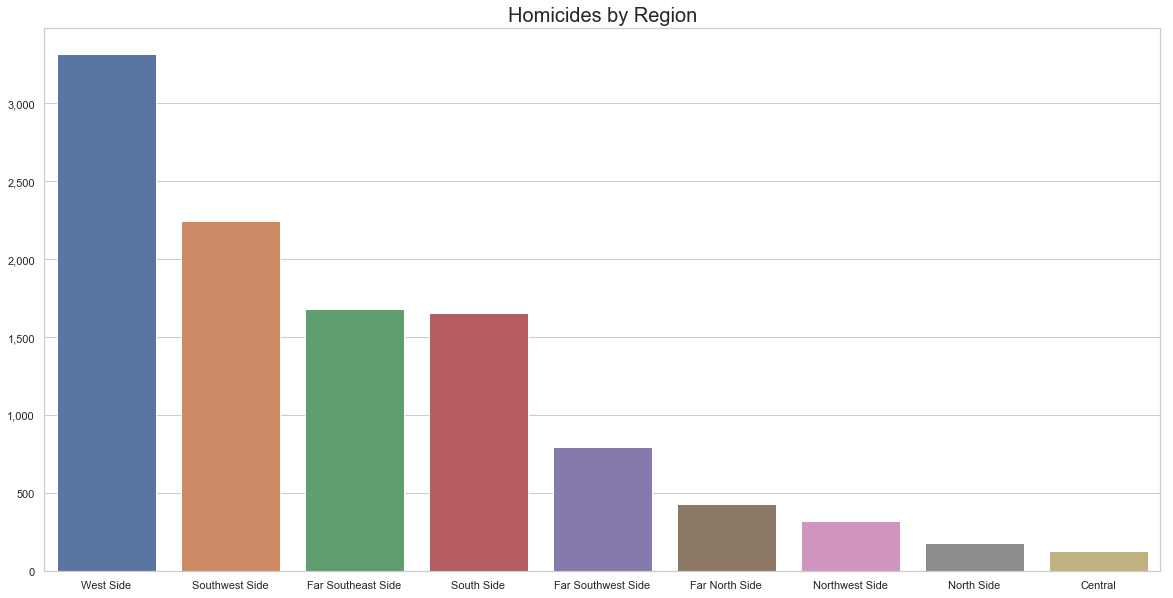

In [133]:
#grouping the homicides by region
region_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Region']).count().iloc[:,0].sort_values(ascending=False).reset_index()
region_hom_counts.columns = ["Region", "Counts"]

#plotting homicides by region
plot_crime(region_hom_counts, x_col="Region", y_col="Counts", title="Homicides by Region")

<a id="comm_areas">

## All Crimes and Homicides by Community Area

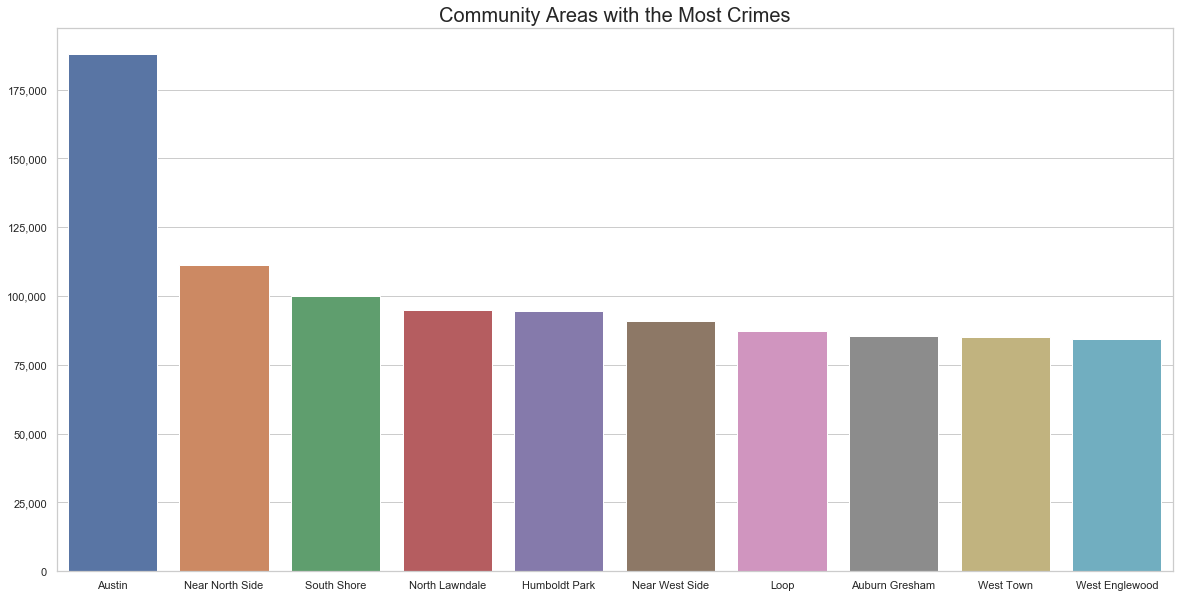

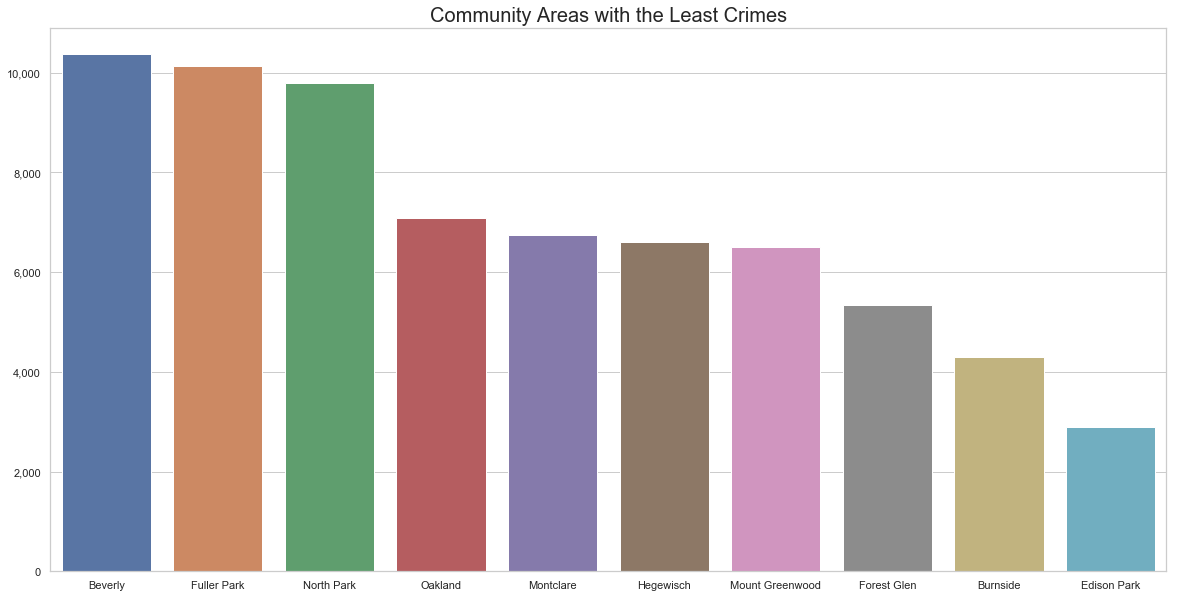

In [132]:
#grouping by community area
comm_area_counts = crimes.groupby(['Community Area']).count().iloc[:,0].sort_values(ascending=False).reset_index()
comm_area_counts.columns = ["Community Area", "Counts"]

#plotting the Community Areas with the 10 highest counts
plot_crime(comm_area_counts[:10], x_col="Community Area", y_col="Counts", title="Community Areas with the Most Crimes")

print()

#plotting the Community Areas with the 10 lowest counts
plot_crime(comm_area_counts[-10:], x_col="Community Area", y_col="Counts", title="Community Areas with the Least Crimes")

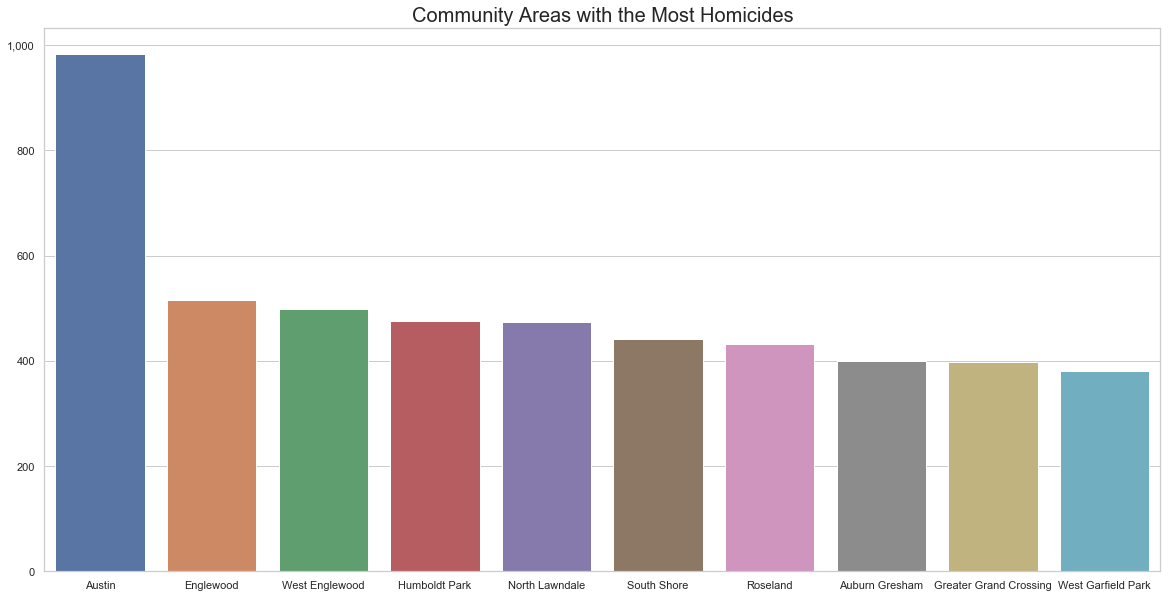

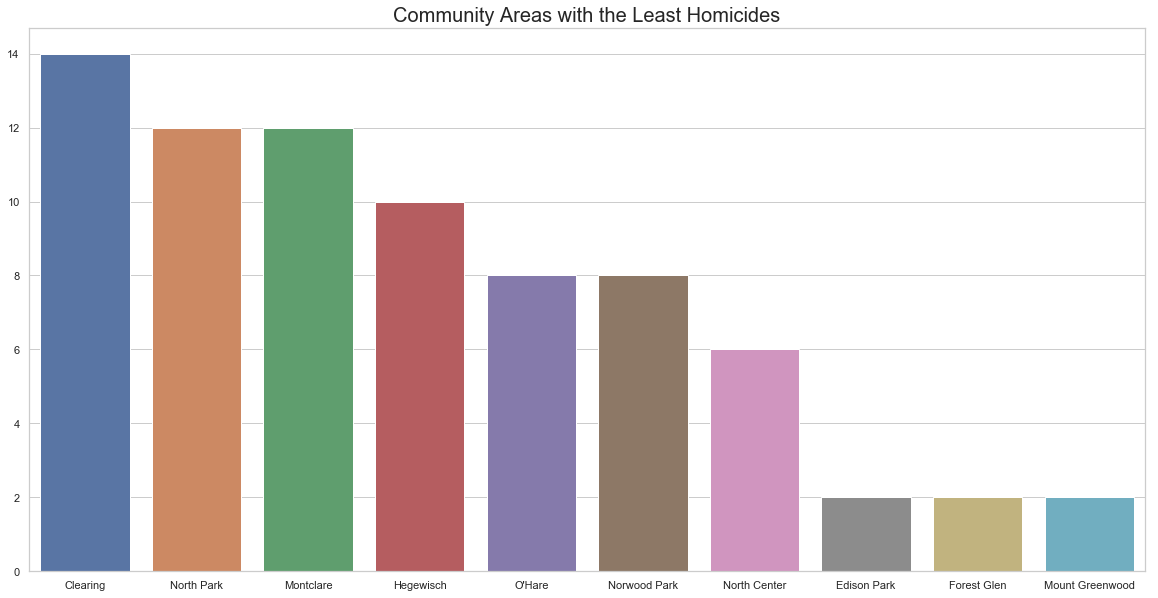

In [134]:
#grouping the homicides by community area
comm_area_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Community Area']).count().iloc[:,0].sort_values(ascending=False).reset_index()
comm_area_hom_counts.columns = ["Community Area", "Counts"]

#plotting the community areas with the most homicides
plot_crime(comm_area_hom_counts[:10], x_col="Community Area", y_col="Counts", 
           title="Community Areas with the Most Homicides")

print()

#plotting the community areas with the least homicides
plot_crime(comm_area_hom_counts[-10:], x_col="Community Area", y_col="Counts", 
           title="Community Areas with the Least Homicides")

<a id="dates">

## Crimes and Homicides by Date Columns

<a id="date">

### Date

In [187]:
#grouping by Year, Month, and Region
date_region_counts = crimes.groupby(['Year','Month','Region']).count().iloc[:,0].reset_index()
date_region_counts.columns = ['Year','Month','Region','Counts']
date_region_counts.sort_values(by=['Year', 'Month'], ascending=True, inplace=True)

#creating Year-Month column and dropping Year and Month
date_region_counts['Year-Month'] = date_region_counts['Year'].astype(str) + '-' + date_region_counts['Month'].astype(str)

In [188]:
date_region_counts.head()

,Year,Month,Region,Counts,Year-Month
0,2010,1,Central,1723,2010-1
1,2010,1,Far North Side,2439,2010-1
2,2010,1,Far Southeast Side,3332,2010-1
3,2010,1,Far Southwest Side,1905,2010-1
4,2010,1,North Side,2018,2010-1


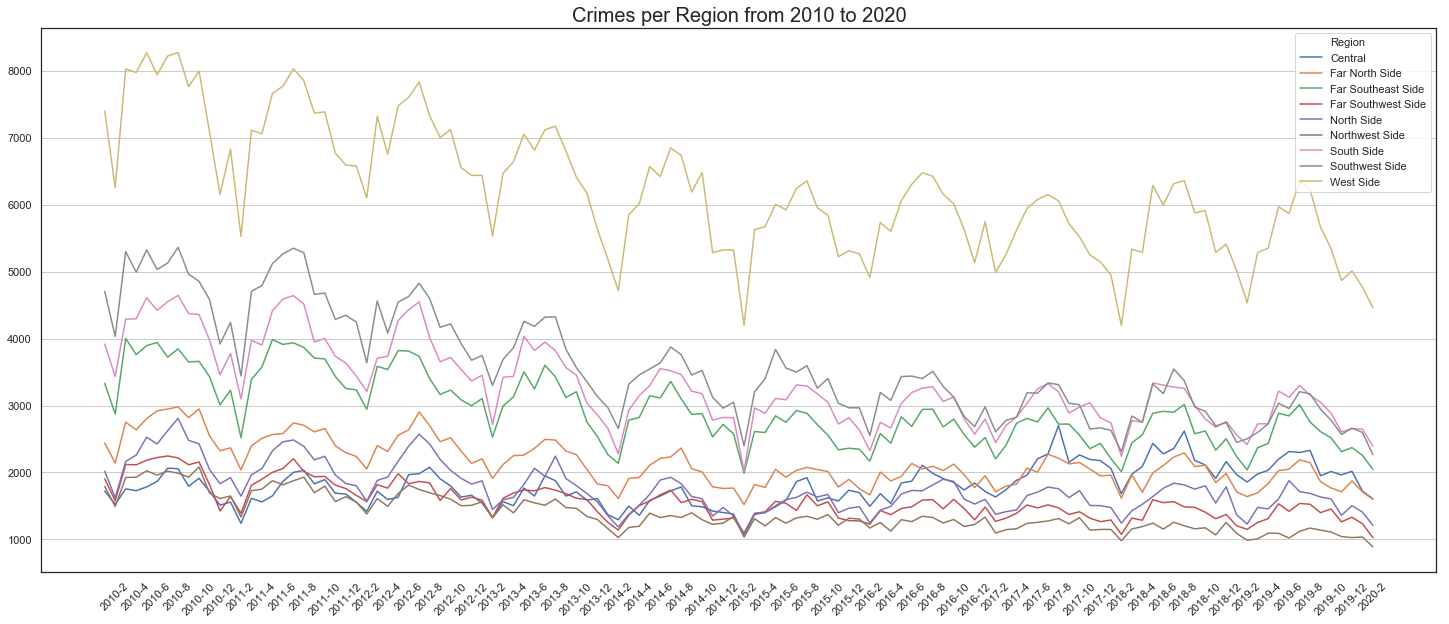

In [193]:
fig,ax = plt.subplots(figsize=(25,10))
ax = sns.lineplot(data=date_region_counts, x="Year-Month", y="Counts", hue="Region", sort=False)

#only showing every other Month-Year label
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.title("Crimes per Region from 2010 to 2020", fontsize=20)
plt.xticks(rotation=45)
ax.xaxis.grid(False)
ax.yaxis.grid(True)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

<a id="time">

### Time of Day

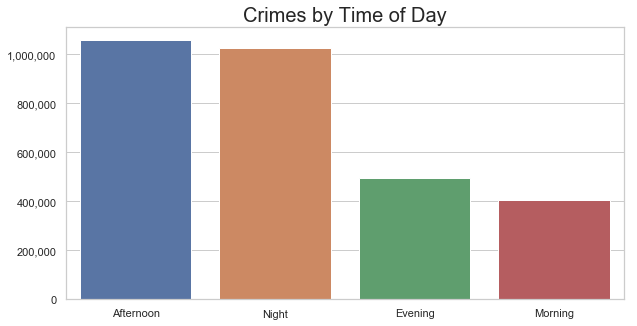

In [140]:
#grouping the crimes by time of day
time_counts = crimes.groupby(['Time of Day']).count().iloc[:,0].sort_values(ascending=False).reset_index()
time_counts.columns = ["Time of Day", "Counts"]

#plotting crimes by time of day
plot_crime(time_counts, x_col="Time of Day", y_col="Counts", title="Crimes by Time of Day", fig_size=(10,5))

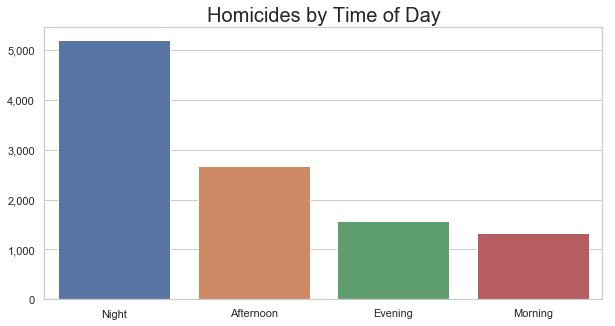

In [142]:
#grouping the homicides by time of day
time_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Time of Day']).count().iloc[:,0].sort_values(ascending=False).reset_index()
time_hom_counts.columns = ["Time of Day", "Counts"]

#plotting homicides by time of day
plot_crime(time_hom_counts, x_col="Time of Day", y_col="Counts", title="Homicides by Time of Day", fig_size=(10,5))

<a id="season">

### Season

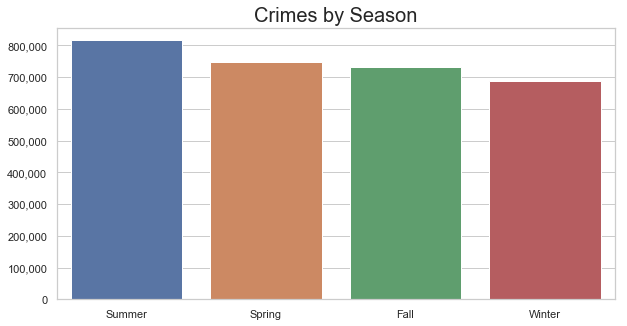

In [138]:
#grouping the crimes by season
season_counts = crimes.groupby(['Season']).count().iloc[:,0].sort_values(ascending=False).reset_index()
season_counts.columns = ["Season", "Counts"]

#plotting crimes by season
plot_crime(season_counts, x_col="Season", y_col="Counts", title="Crimes by Time of Day", fig_size=(10,5))

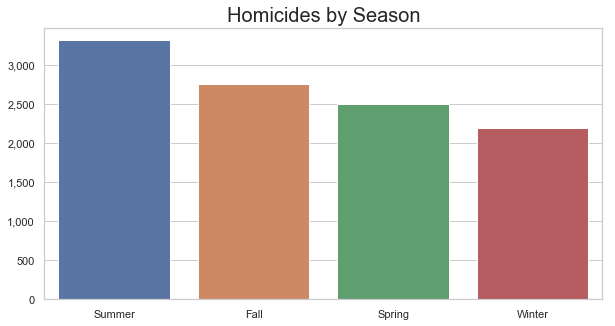

In [137]:
#grouping the homicides by season
season_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Season']).count().iloc[:,0].sort_values(ascending=False).reset_index()
season_hom_counts.columns = ["Season", "Counts"]

#plotting homicides by season
plot_crime(season_hom_counts, x_col="Season", y_col="Counts", title="Homicides by Season", fig_size=(10,5))